In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [30]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
# Remove NaN rows in data

df_no_nan = df.dropna()
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
# Standardize data

features = df.columns
x = new_df.loc[:, features].values

x = StandardScaler().fit_transform(x)

In [33]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)

In [34]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9'])

In [35]:
print(pca.explained_variance_ratio_)

[0.26138907 0.19714578 0.12446946 0.09799499 0.09384705 0.08165203
 0.05426927 0.04646457 0.0427678 ]


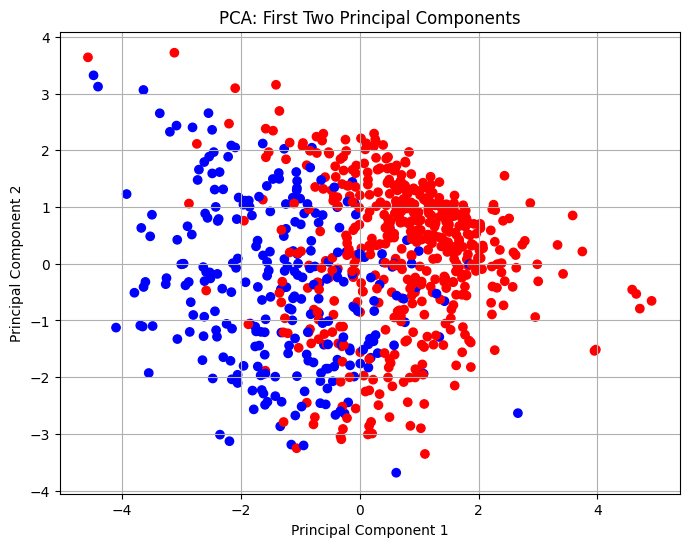

In [39]:
# Plotting 2D
colors = ["blue" if i else "red" for i in new_df["Outcome"]]
plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.grid(True)
plt.show()